In [22]:
# Data Encoding in Qiskit

# 1. Simple Data Encoding (Manual)
# 2. Statevector Encoding 
# 3. Complex Data Encoding

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
start = time.time()
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute, assemble
from qiskit.circuit.library import HGate, ZGate, XGate
from qiskit import BasicAer, Aer
from qiskit.aqua.circuits import StateVectorCircuit
from qiskit.visualization import plot_histogram
from math import sqrt,pi

In [10]:
# 1. Simple Data Encoding
# We want to encode a bit-string 1101001 in 7 qubits
# Remember: in Qiskit the leftmost bit is represented in lowermost qubit (e.g., 7th qubit in a 7-qubit system)
# Why? bcos qubit 7 is telling us about how many 2^7 s we have in the decimal number that the bitstring represents
n=7
qc_encoded = QuantumCircuit(n)
qc_encoded.x(0)
qc_encoded.x(3)
qc_encoded.x(5)
qc_encoded.x(6)
qc_encoded.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘
q_4: ─────
     ┌───┐
q_5: ┤ X ├
     ├───┤
q_6: ┤ X ├
     └───┘

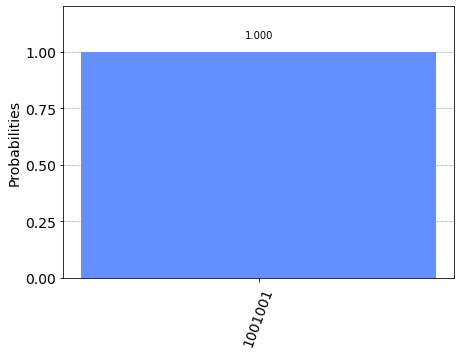

In [9]:
# Now we want to visualise the encoding by measuring it
m_qubits = n 
m_bits = n
# We create another circuit to measure using m_qubits qubits and m_bits classical bits
qc_measure = QuantumCircuit(m_qubits,m_bits)

# We apply measure gates in all the qubits
for j in range(n):
    qc_measure.measure(j,j)

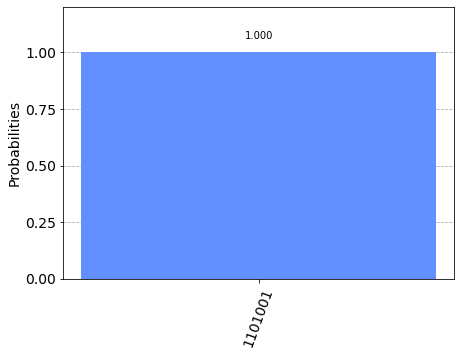

In [11]:
# Now we assemble the encoded circuit and the measurement circuits to create a new circuit    
qc = qc_encoded + qc_measure
qobj = assemble(qc) # circuit to an object the backend can run

qsimulator = Aer.get_backend('qasm_simulator')  # this is the simulator we'll use
result = qsimulator.run(qobj).result()  # we run the experiment and get the result from that experiment
counts = result.get_counts()
# and display it on a histogram
plot_histogram(counts)

In [23]:
# 2. Statevector Encoding
initial_state = [0,1]   # Define initial_state as |1>
initial_state = [1/sqrt(2), 1j/sqrt(2)]
initial state = [1/3, 2/3]

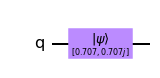

In [24]:
qc = QuantumCircuit(1)  # Create a quantum circuit with one qubit
qc.initialize(initial_state, 0) # Apply initialisation operation to the 0th qubit
qc.draw(output='mpl')

In [26]:
qc.measure_all()

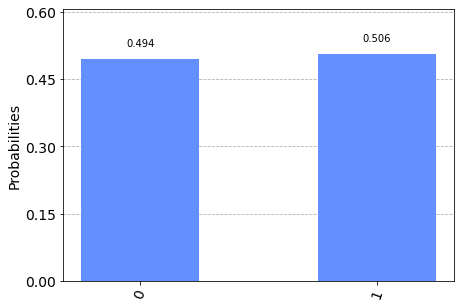

In [27]:
qobj = assemble(qc) # circuit to an object the backend can run
result = qsimulator.run(qobj).result()  # we run the experiment and get the result from that experiment
counts = result.get_counts()
# and display it on a histogram
plot_histogram(counts)

In [14]:
# 2. Complex Data Encoding
# We have a k-dimensional data sample - We use the the data as amplitudes to the statevector
# We are using amplitude encoding to encode 'the features' in a quantum circuit. 
# With this we expect to encode 32 features in five qubits.

# For such encoding we will use StateVectorCircuit. 
state_vector = [-1/2, 1/2, 1/2, -1/2]
state_vector_circuit = StateVectorCircuit(state_vector).construct_circuit()
state_vector_circuit.draw()


<ipython-input-14-b3119565990b>:8: DeprecationWarning: The StateVectorCircuit class is deprecated as of Qiskit Aqua 0.9.0 and will be removed no earlier than 3 months after the release. If you need to initialize a circuit, use the QuantumCircuit.initialize or QuantumCircuit.isometry methods. For a parameterized initialization, try the qiskit.ml.circuit.library.RawFeatureVector class.
  state_vector_circuit = StateVectorCircuit(state_vector).construct_circuit()


┌────────────┐┌───┐┌──────────┐┌───────────┐┌───┐┌──────────┐
q_0: ┤ U(π/2,0,0) ├┤ X ├┤ U(0,0,0) ├┤ U(0,0,-π) ├┤ X ├┤ U(0,0,0) ├
     ├────────────┤└─┬─┘└──────────┘└───────────┘└─┬─┘└──────────┘
q_1: ┤ U(π/2,0,0) ├──■─────────────────────────────■──────────────
     └────────────┘

In [15]:
job = execute(state_vector_circuit, Aer.get_backend('statevector_simulator'), optimization_level=0)
result = job.result()

outputstate = result.get_statevector(state_vector_circuit)

print(outputstate)
print(state_vector)

[ 0.5+0.000000e+00j -0.5-6.123234e-17j -0.5-6.123234e-17j
  0.5+0.000000e+00j]
[-0.5, 0.5, 0.5, -0.5]


### The StateVectorCircuit does not respect global phase

The target state,$|\psi_{t}\rangle$, i.e. `[-0.5+0.j -0.5+0.j -0.5+0.j -0.5+0.j]` and the state $|\psi\rangle$ that we get `[0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]` differ by a total factor of $-1$, i.e.,

$$
|\psi\rangle = (-1)\times|\psi_{t}\rangle = -|\psi_{t}\rangle.
$$
Such an overall factor is known as a *global* phase. People think of it as a phase, because we can write $-1 = e^{i\phi}$ for $\phi=\pi$. Note that QISKIT not only considers global phases when $\phi$ *is* equal to $\pi$, but $\phi$ can be anything between $0$ and $2\pi$.

Qiskit does not care about global phases, because whenever we try to retrieve information (i.e. a measurement) from a state the global phase **cannot** play a role. Therefore, we normally just disregard the global phase, and we set the first entry in our statevector to a real, positive value.

However, the sign difference between elements in the above statevector $|\psi_{t}\rangle$, *does* play a vital role. It is the *relative* phase, because it is a phase of one element of the statevector relative to the other. Also note that if we limit ourselves to only real elements (thereby setting any relative phase $\phi_{rel}$ to $0$ or $\pi$), we severely limit the quantum advantage that we can attain.

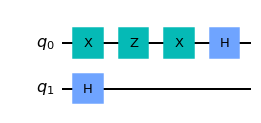

In [16]:
#Create the Measurement Circuit
qc = QuantumCircuit(2)
x = XGate()
h = HGate()
z = ZGate()
qc.append(x,[0])
qc.append(z,[0])
qc.append(x,[0])
qc.append(h,[0])
qc.append(h,[1])
qc.draw('mpl')

In [17]:
job = execute(qc, Aer.get_backend('statevector_simulator'), optimization_level=0)
result = job.result()

outputstate = result.get_statevector(qc)

print(outputstate)
print(state_vector)

[-0.5+0.j -0.5+0.j -0.5+0.j -0.5+0.j]
[-0.5, 0.5, 0.5, -0.5]
